# k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline and cross-validation.

You can choose if you implement the distance computation using a fully vectorized version, or using one or two for-loops. 
Vectorization is going to be much faster than using for loops, but using two for loops is perhaps the most straightforward implementation. 

We will work on the CIFAR-10 image data, which is a common dataset with 10 object classes. To make computation fast,  the images are small, 32x32x3 (RGB) pixels. 


If you are on a linux computer at IFI, use the data path /projects/in5400/CIFAR-10/cifar-10-batches-py



* First, download the image data, go to in5400/datasets and execute get_datasets.sh


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from in5400.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#from __future__ import print_function


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'in5400/datasets/cifar-10-batches-py'
#cifar10_dir = '/projects/in5400/CIFAR-10/cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
print(y_test[:10])

[3 8 8 0 6 6 1 6 3 1]


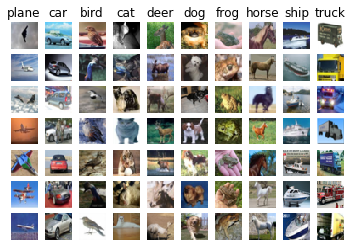

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
print(y_test.shape)

(500,)


# Reshape data

It is common to reshape the images to a long vector of size [32x32,1]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [20]:
from in5400.classifiers import KNearestNeighbor
from in5400.classifiers.k_nearest_neighbor import *
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `inf5860/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances` that uses computes the euclidean distance between all pairs of (test, train) examples and computes the distance matrix one element at a time.

You can choose to implement the distance  using for loops (slow), or using full vectorization (no for loops over the samples).

In [58]:
# Open in5400/classifiers/k_nearest_neighbor.py and implement
# compute_distances.

# Test your implementation:
dists = classifier.compute_distances(X_test)
print(dists.shape)
print(dists[:10,:10])

(500, 5000)
[[3803.92350081 4210.59603857 5504.0544147  3473.88960677 4371.58632535
  4447.85127899 3886.35060179 4058.59187404 5175.54760388 4678.74855063]
 [6336.83367306 5270.28006846 4040.63608854 6430.498892   5350.64407338
  6094.37987001 5271.94688896 6546.65173963 5710.24097565 6404.07628   ]
 [5224.83913628 4250.64289255 3773.94581307 5213.55799814 3761.53572361
  5260.55082667 4366.72863824 5405.09962905 4601.2692814  5246.72850451]
 [5265.83754022 4274.49459001 4593.32254474 5692.80598651 4982.8210885
  5412.18920586 4307.1045959  5189.83997827 4967.28356348 6262.7882768 ]
 [3163.80277514 4231.52395716 6134.35889071 2953.75032797 4255.45825969
  4356.26824243 3837.93551275 3835.97028143 4923.86403143 5053.92876879]
 [3072.51281527 4256.22179873 5351.42317519 2671.23492041 4312.94980263
  3257.88551057 3740.6830927  4275.40816765 5648.30788821 3967.44968462]
 [4184.89462233 5506.63908387 6925.23934604 3630.96846585 5154.49124551
  4669.09156046 5263.9629558  5601.23138247 699

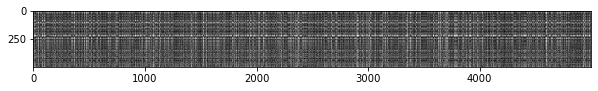

In [59]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

In [61]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
print(y_test_pred[:30])

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[4. 9. 8. 8. 4. 4. 3. 2. 5. 8. 2. 8. 5. 7. 2. 2. 5. 3. 1. 4. 2. 0. 0. 6.
 2. 4. 2. 7. 2. 6.]
Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [62]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

You should split the training data into a set used for training and a set used for validation, and estimate the classification accuracy on the validation part, with the current value of k, then we iteratate over different values of k. We use num_folds folds in cross-validation.

In [13]:
num_folds = 5
k_choices = [1, 3, 5,  10, 12, 15]



################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [14]:


# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
nk = len(k_choices)
#k_to_accuracies = np.zeros((nk))
################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################


    
            
            
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [15]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

KeyError: 1

In [16]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10



classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000


In [11]:
A = np.arange(12).reshape(3,4)
print(A)
print(np.square(A))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[  0   1   4   9]
 [ 16  25  36  49]
 [ 64  81 100 121]]


In [19]:
a = np.arange(4)
b = np.arange(18).reshape(3,6)
print(a)
print(b)

print(np.sum(b, axis = 1))
np.sum(b, axis = 1)[:, np.newaxis]

[0 1 2 3]
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
[15 51 87]


array([[15],
       [51],
       [87]])

In [38]:
a = np.array([3,3,2,2])
counts = np.bincount(a)
print( np.argmax(counts))

2


In [52]:
a = np.array([[1,10,3],[100,6,5]])
np.argsort(a[0,:])

array([0, 2, 1])